In [1]:
# Core DL & Utility Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage, stats
from scipy.stats import randint as sp_randint
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization,
    Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
)
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Model Wrappers & Classical ML
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV,
    ShuffleSplit, PredefinedSplit, cross_val_score
)
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.utils import resample

# File Handling
from pandas import ExcelFile, ExcelWriter
import openpyxl
import xlsxwriter
import h5py

# Visualization
import matplotlib.pyplot as plt
from IPython.display import SVG

# Misc
import pydot
import scipy


2025-10-17 12:53:27.303041: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-17 12:53:27.712498: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-17 12:53:29.654988: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:


from __future__ import print_function
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
 
from matplotlib import pyplot as plt
%matplotlib inline
print("RDKit: %s"%rdkit.__version__)



RDKit: 2025.03.6


In [3]:
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

print("TensorFlow:", tf.__version__)
print("Keras:", tf.keras.__version__)


TensorFlow: 2.20.0
Keras: 3.11.3


In [5]:
data = pd.read_csv('/home/dito-adistya/Dito/TA/Coding/LSTM-MBA/data/GSARPC3.csv')
df = data 

In [38]:
df

,cid,smiles,acvalue,categories
0,44244736,COC1=C(C(=C(C=C1)C2=C(OC(=N2)C3=CC=CC=C3F)SC4=...,0.0030,inhibitor
1,44244911,CC1=NN=C(S1)SC2=C(N=C(O2)C3=CC=CC=C3F)C4=C(C(=...,0.0035,inhibitor
2,44245235,COC1=C(C(=C(C=C1)C2=C(OC(=N2)C3=CN=CC=C3)SC4=N...,0.0047,inhibitor
3,10451021,CC(=CC1=CC(=C(C=C1)OC)O)C(=O)C2=CC(=C(C(=C2)OC...,0.0090,inhibitor
4,44245073,CC1=CN=C(N=C1C)SC2=C(N=C(O2)C3=CC=CC=C3Cl)C4=C...,0.0180,inhibitor
...,...,...,...,...
631,145958114,COC1=CC=C(C=C1)C(=O)C=CC2=CC=C(C=C2)N3C=C(N=N3...,100.0000,neutral
632,145950639,C1=CC=C(C=C1)C2=C(N=NC(=N2)SCC3=CN(N=N3)CC4=CC...,100.0000,neutral
633,3168508,C1=CC=C(C=C1)C2=C(N=NC(=N2)SCCC(=O)O)C3=CC=CC=C3,100.0000,neutral
634,145952863,CC(C)CC(C(=O)NO)NC(=O)NCC1=CN(N=N1)CC2=CC=CC=C...,119.1000,neutral


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Misal kolom label/target namanya 'label'
X = df.drop('categories', axis=1)
y = df['categories']

# Split dengan stratifikasi → jaga proporsi kelas di train & test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # 🔑 INI YANG PENTING!
)

# Gabung lagi jadi dataframe
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Simpan
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("Distribusi label di train:")
print(y_train.value_counts(normalize=True))
print("\nDistribusi label di test:")
print(y_test.value_counts(normalize=True))

Distribusi label di train:
categories
neutral      0.503937
inhibitor    0.496063
Name: proportion, dtype: float64

Distribusi label di test:
categories
neutral      0.507812
inhibitor    0.492188
Name: proportion, dtype: float64


In [40]:
df_train = pd.read_csv('/home/dito-adistya/Dito/TA/Coding/LSTM-MBA/data/Train/train.csv')
df_test = pd.read_csv('/home/dito-adistya/Dito/TA/Coding/LSTM-MBA/data/Test/test.csv')

In [61]:


X_train_smiles = np.array(list(df_train["smiles"]))
X_test_smiles = np.array(list(df_test["smiles"]))
print(X_train_smiles.shape)
print(X_test_smiles.shape)



(508,)
(128,)


In [62]:


assay = "categories"  
Y_train = df_train[assay].values.reshape(-1,1)
Y_test = df_test[assay].values.reshape(-1,1)



In [63]:

charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print (str(charset))
print(len(charset), embed)

{'8', '1', 'N', '+', '.', 'O', 'E', ']', ')', '=', '9', '-', '6', '#', 'l', '[', '4', '(', 'C', 'r', 'F', '7', '!', '3', 'I', 'S', '2', '5', 'B'}
29 168


In [64]:
char_to_int 

{'8': 0,
 '1': 1,
 'N': 2,
 '+': 3,
 '.': 4,
 'O': 5,
 'E': 6,
 ']': 7,
 ')': 8,
 '=': 9,
 '9': 10,
 '-': 11,
 '6': 12,
 '#': 13,
 'l': 14,
 '[': 15,
 '4': 16,
 '(': 17,
 'C': 18,
 'r': 19,
 'F': 20,
 '7': 21,
 '!': 22,
 '3': 23,
 'I': 24,
 'S': 25,
 '2': 26,
 '5': 27,
 'B': 28}

In [78]:
def smiles_to_int(smiles_list, char_to_int, max_len):
    sequences = []
    for smile in smiles_list:
        seq = [char_to_int['!']]  # start token
        seq += [char_to_int[c] for c in smile]
        seq += [char_to_int['E']] * (max_len - len(smile) - 1)  # pad with end token
        sequences.append(seq[:max_len])  # pastikan panjang = max_len
    return np.array(sequences, dtype=np.int32)

max_length = embed - 1  # karena di vectorize lu pake embed-1
X_train = smiles_to_int(X_train_smiles, char_to_int, max_length)
X_test = smiles_to_int(X_test_smiles, char_to_int, max_length)

# Cek
print("X_train shape:", X_train.shape)  # Harus (508, max_length)
print("X_train dtype:", X_train.dtype)  # Harus int32

X_train shape: (508, 167)
X_train dtype: int32


In [67]:
X_train[8]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [68]:
mol_str_train=[]
mol_str_test=[]
for x in range(508):
 
    mol_str_train.append("".join([int_to_char[idx] for idx in np.argmax(X_train[x,:,:], axis=1)]))
    
    
for x in range(128):
    mol_str_test.append("".join([int_to_char[idx] for idx in np.argmax(X_test[x,:,:], axis=1)]))

In [69]:
vocab_size=len(charset)

In [79]:
model = Sequential([
    Embedding(vocab_size, 50, input_length=embed-1),
    Conv1D(192, 10, activation='relu'),
    BatchNormalization(),
    Conv1D(192, 5, activation='relu'),
    Conv1D(192, 3, activation='relu'),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # atau 'sigmoid' kalau klasifikasi biner
])

In [71]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [80]:
def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

In [81]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate  # 🔑 di TF 2.x, ini 'learning_rate', bukan 'lr'
    return lr

In [82]:
mol_str_train = np.asarray(mol_str_train)
mol_str_test = np.asarray(mol_str_test)

In [83]:
# Setup optimizer & metrics
optimizer = Adam(learning_rate=0.00025)  # TF 2.x style
lr_metric = get_lr_metric(optimizer)

In [84]:
# Compile model
model.compile(
    loss="mse",
    optimizer=optimizer,
    metrics=[coeff_determination, lr_metric]
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# ✅ Callbacks (import dari tf.keras.callbacks)
callbacks_list = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-15,
        verbose=1,
        mode='auto',
        cooldown=0
    ),
    ModelCheckpoint(
        filepath="weights.best.keras",  # 👈 .keras lebih safe di TF baru
        monitor='val_loss',
        save_best_only=True,
        verbose=1,
        mode='auto'
    )
]

# ❗ JANGAN pake np.argmax() kalau input lu adalah sequence integer!
# Input ke model dengan Embedding HARUS integer, bukan one-hot!
# Jadi: X_train dan X_test harus berupa array integer (misal: [[3,5,1,...], ...])

history = model.fit(
    x=X_train,          # ← BUKAN np.argmax(X_train, axis=2)
    y=Y_train,
    batch_size=128,
    epochs=150,
    validation_data=(X_test, Y_test),  # ← BUKAN np.argmax(X_test, ...)
    callbacks=callbacks_list
)

ValueError: Invalid dtype: object

In [59]:
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("Sample:", X_train[0][:10])  # 10 karakter pertama SMILES pertama

X_train shape: (508, 167, 29)
X_train dtype: int8
Sample: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]


/home/abdulkarim/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


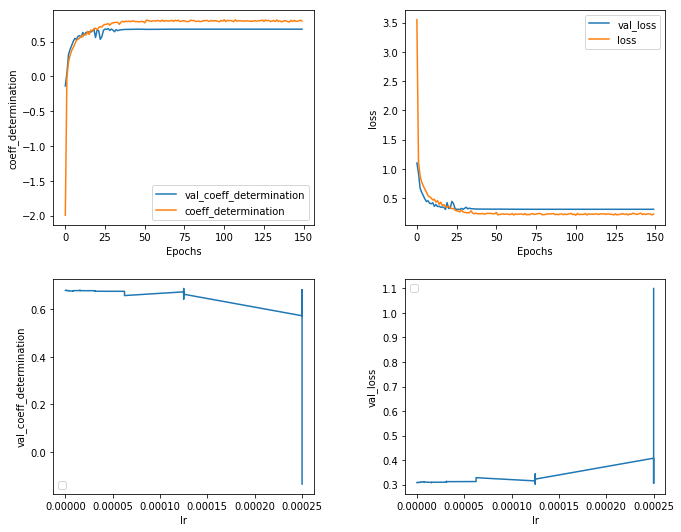

In [621]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(221)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(222)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")



plt.subplot(223)
plt.plot( hist['lr'],hist['val_coeff_determination']  )
plt.legend()
plt.xlabel("lr")
plt.ylabel("val_coeff_determination")


plt.subplot(224)
plt.plot( hist['lr'],hist['val_loss']  )
plt.legend()
plt.xlabel("lr")
plt.ylabel("val_loss")

    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

In [87]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, BatchNormalization

# === 1. Baca data asli ===
df = pd.read_csv('/home/dito-adistya/Dito/TA/Coding/LSTM-MBA/data/Train/GSARPC3.csv')  # Ganti sama path data lu
smiles_list = df['smiles'].str.upper().tolist()
targets = df['categories'].values  # atau kolom label lu

# === 2. Bikin vocab (sama kayak sebelumnya) ===
all_chars = set(''.join(smiles_list))
charset = ['!', 'E', '?'] + sorted(all_chars)
char_to_int = {c: i for i, c in enumerate(charset)}
vocab_size = len(charset)
max_len = max(len(s) for s in smiles_list) + 3

# === 3. Encode SMILES jadi integer sequence ===
def smiles_to_seq(smiles, char_to_int, max_len):
    seq = [char_to_int['!']]
    for c in smiles:
        seq.append(char_to_int.get(c, char_to_int['?']))
    seq.append(char_to_int['E'])
    if len(seq) < max_len:
        seq += [char_to_int['?']] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return seq

X = np.array([smiles_to_seq(s, char_to_int, max_len) for s in smiles_list], dtype=np.int32)

# === 4. Bangun SMILES2Vec encoder ===
inputs = Input(shape=(max_len,))
x = Embedding(vocab_size, 64)(inputs)
x = Conv1D(192, 10, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv1D(192, 5, activation='relu', padding='same')(x)
x = Conv1D(192, 3, activation='relu', padding='same')(x)
x = GlobalMaxPooling1D()(x)
embedding = Dense(128, activation='relu', name='embedding')(x)

encoder = Model(inputs=inputs, outputs=embedding)

# === 5. Ekstrak embedding ===
embeddings = encoder.predict(X, verbose=1)  # shape: (n_samples, 128)

# === 6. Simpan ke file ===
# Opsi A: Simpan sebagai CSV (mudah dibaca)
embedding_df = pd.DataFrame(embeddings)
embedding_df['target'] = targets  # tambahin label
embedding_df.to_csv('smiles2vec_embeddings.csv', index=False)


print("✅ Embedding berhasil disimpan!")
print("Shape:", embeddings.shape)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
✅ Embedding berhasil disimpan!
Shape: (636, 128)
